# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет внедряет систему компьютерного зрения для обработки изображений покупателей. Фотофиксация в зоне касс поможет определять возраст клиентов с целью:
- Анализа покупок и предложения товаров, которые могут заинтересовать клиентов определенной возрастной группы;
- Контроля добросовестности кассиров при продаже алкогольной продукции.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.rcParams["figure.figsize"] = (16,8)

Для начала загрузим данные, и оценим размер выборки, распределение возрастов в ней, проверим отсутствие пропусков.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


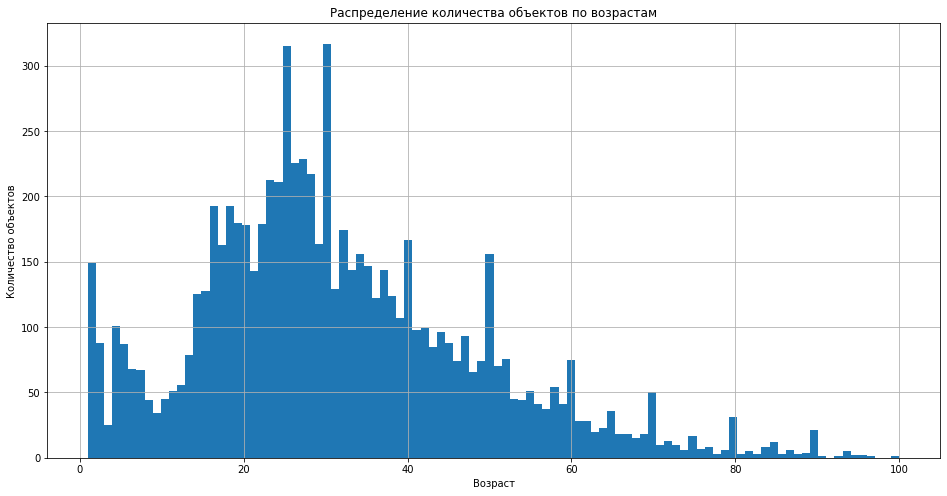

In [4]:
labels.hist(bins=100)
plt.title('Распределение количества объектов по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество объектов');

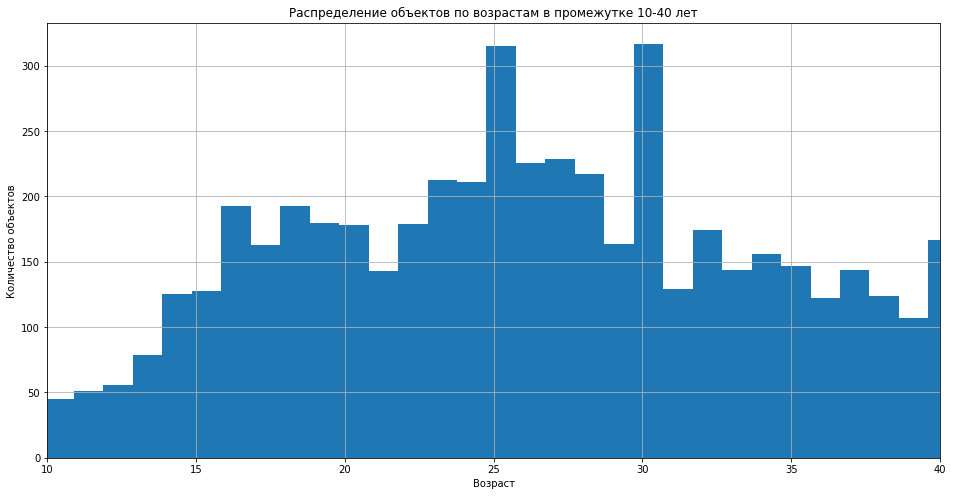

In [5]:
labels.hist(bins=100)
plt.title('Распределение объектов по возрастам в промежутке 10-40 лет')
plt.xlabel('Возраст')
plt.ylabel('Количество объектов')
plt.xlim(10, 40);

Распределение скошено влево - при минимуме в 1 год и максимуме в 100 лет больше половины объектов не превышают отметку 30 лет. Скорее всего, это скажется на обучении - модель будет хорошо предсказывать возраст 20-40 летних и хуже - более взрослых людей и детей.

Наблюдаются заметные пики в 1, 25, 30, 40, 50, 60 лет. Возможно, для некоторых объектов возраст был округлен или выставлен примерно.

Рассмотрим фото подробнее

In [6]:
features, target = next(train_gen_flow)

Фото №1
Возраст:50


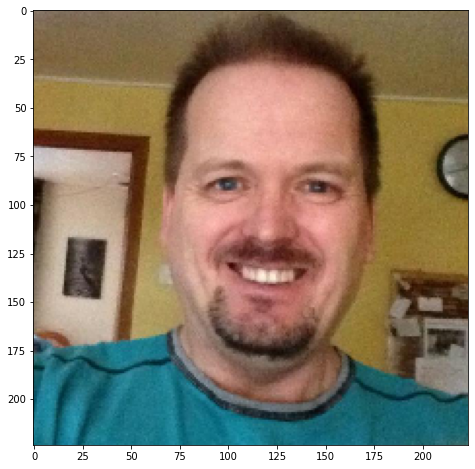

Фото №2
Возраст:41


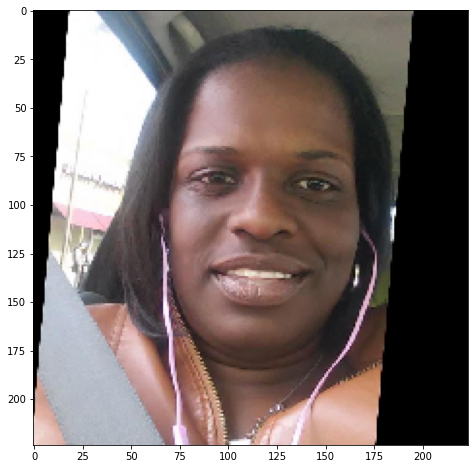

Фото №3
Возраст:46


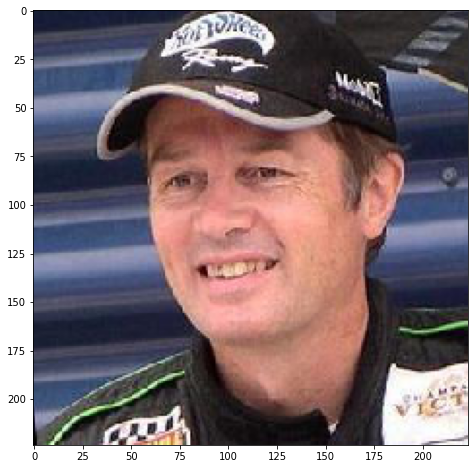

Фото №4
Возраст:85


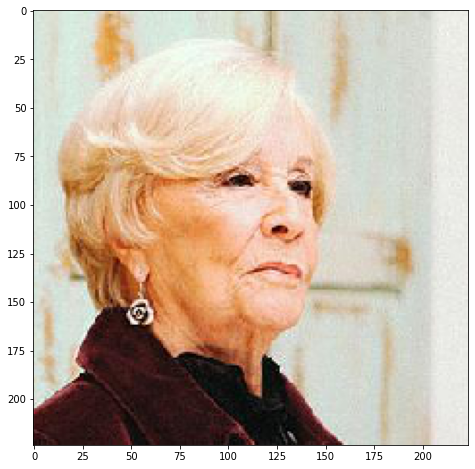

Фото №5
Возраст:14


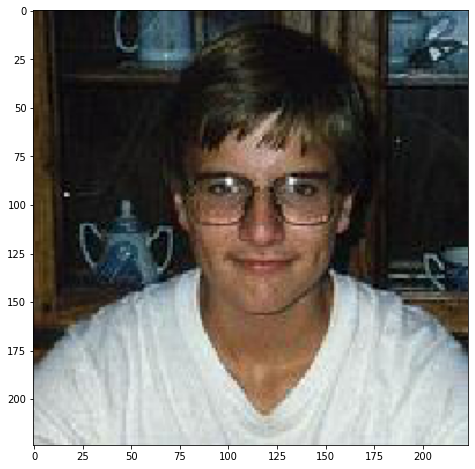

Фото №6
Возраст:40


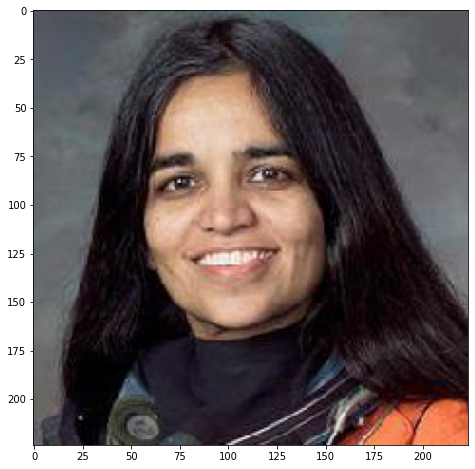

Фото №7
Возраст:14


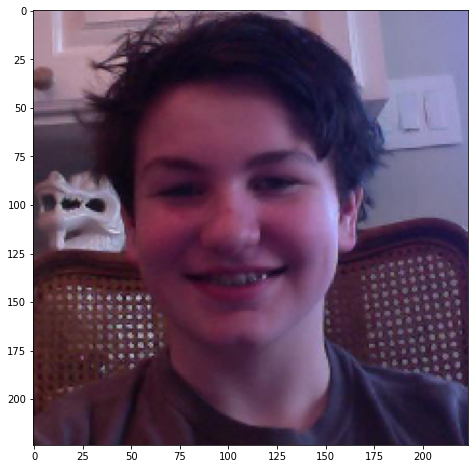

Фото №8
Возраст:53


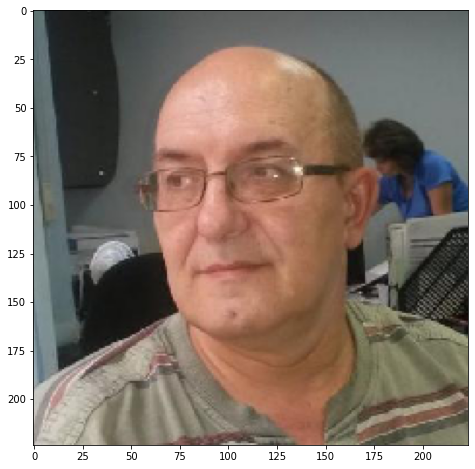

Фото №9
Возраст:4


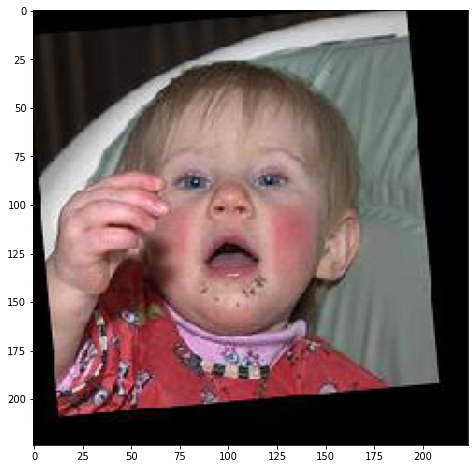

Фото №10
Возраст:32


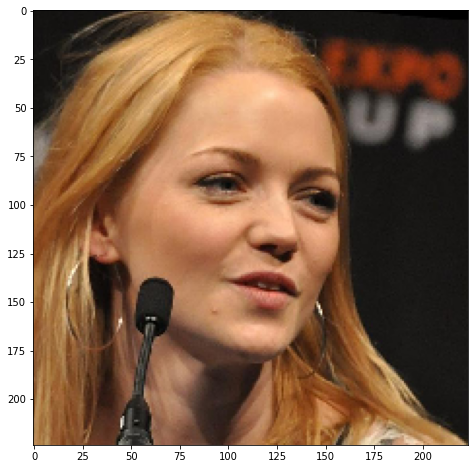

In [7]:
for i in range(10):
    print(f'Фото №{i+1}')
    print(f'Возраст:{target[i]}')
    plt.imshow(features[i])
    plt.show()

Изображения различного качества и цветовой гаммы, люди на них разного пола, возраста и выражают разные эмоции. Соответствие возраста и фото выглядит правдоподобно.

На некоторых объектах заметны последствия поворота на некоторый градус, значит они были предварительно обрезаны и обработаны так, чтобы лицо находилось примерно в центре изображения.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


def load_train(path):

    datagen = ImageDataGenerator(
        zoom_range = 0.2,
        horizontal_flip = True,
        rescale=1/255,
        validation_split=0.25
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return datagen_flow


def load_test(path):

    datagen = ImageDataGenerator(
        rescale=1/255,
        validation_split=0.25)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])

    return model

def train_model(model,train_datagen_flow,
                test_datagen_flow,
                batch_size=None, epochs=15,
                steps_per_epoch=None,
                validation_steps=None):

    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 101s - loss: 24.8958 - mean_absolute_error: 24.8958 - val_loss: 29.5982 - val_mean_absolute_error: 29.6162
Epoch 2/15
178/178 - 94s - loss: 10.6833 - mean_absolute_error: 10.6834 - val_loss: 29.5978 - val_mean_absolute_error: 29.6158
Epoch 3/15
178/178 - 94s - loss: 8.2451 - mean_absolute_error: 8.2454 - val_loss: 27.4801 - val_mean_absolute_error: 27.4990
Epoch 4/15
178/178 - 94s - loss: 7.3136 - mean_absolute_error: 7.3141 - val_loss: 11.8758 - val_mean_absolute_error: 11.8433
Epoch 5/15
178/178 - 95s - loss: 6.7207 - mean_absolute_error: 6.7211 - val_loss: 7.8313 - val_mean_absolute_error: 7.8347
Epoch 6/15
178/178 - 94s - loss: 6.3263 - mean_absolute_error: 6.3265 - val_loss: 6.6063 - val_mean_absolute_error: 6.6270
Epoch 7/15
178/178 - 94s - loss: 5.9610 - mean_absolute_error: 5.9616 - val_loss: 6.9170 - val_mean_absolute_error: 6.9327
Epoch 8/15
178/178 - 94s - loss: 5.6602 - mean_absolute_error: 5.6606 - val_loss: 7.4571 - val_mean_absolute_error: 7.4563
Epoch 9/15
178/178 - 94s - loss: 5.3991 - mean_absolute_error: 5.3993 - val_loss: 6.5655 - val_mean_absolute_error: 6.6029
Epoch 10/15
178/178 - 94s - loss: 5.2388 - mean_absolute_error: 5.2392 - val_loss: 6.5153 - val_mean_absolute_error: 6.5476
Epoch 11/15
178/178 - 94s - loss: 4.9262 - mean_absolute_error: 4.9270 - val_loss: 6.4604 - val_mean_absolute_error: 6.4949
Epoch 12/15
178/178 - 94s - loss: 4.7891 - mean_absolute_error: 4.7897 - val_loss: 6.3640 - val_mean_absolute_error: 6.3918
Epoch 13/15
178/178 - 94s - loss: 4.5682 - mean_absolute_error: 4.5686 - val_loss: 6.8602 - val_mean_absolute_error: 6.9079
Epoch 14/15
178/178 - 92s - loss: 4.5038 - mean_absolute_error: 4.5042 - val_loss: 6.8667 - val_mean_absolute_error: 6.9209
Epoch 15/15
178/178 - 91s - loss: 4.3213 - mean_absolute_error: 4.3217 - val_loss: 6.3384 - val_mean_absolute_error: 6.3600

60/60 - 10s - loss: 6.3384 - mean_absolute_error: 6.3600
Test MAE: 6.3600
```

## Анализ обученной модели

**Вывод:**

Для работы был предоставлен датасет предобработанных фото с изображениями лиц различного возраста в объеме 7591 объектов.

Так как фотографии приведены к схожему виду, аугментация обучающей выборки была незначительной.
В основе модели лежит сверточная нейронная сеть архитектуры ResNet50. Обученная модель показывает результат MAE в 6.3, что значит, что модель при предсказании возраста в среднем ошибается на 6,3 лет.

Исходя из полученных результатов, модель может быть использована для анализа покупок и персональных предложений, исходящих из возрастной группы клиента.
Контролировать добросовестность кассиров при продаже алкоголя при помощи этой модели не рекомендуется.